In [59]:
import fiftyone as fo
import numpy as np
import matplotlib.pyplot as plt 
import tqdm
from skimage.measure import block_reduce

dataset = fo.load_dataset('RumexWeeds')


def get_boxes(field, width, height, unwound=True):
    gt_boxes = [] 
    if unwound:
        for box in dataset.values(field):
            if box is None:
                gt_boxes.append([np.nan for _ in range(4)]) 
            else:
                [gt_boxes.append(x) for x in box]
        gt_boxes = np.asarray(gt_boxes)
        gt_boxes[:,::2] = gt_boxes[:, ::2]*width
        gt_boxes[:, 1::2] = gt_boxes[:, 1::2]*height
        gt_boxes = gt_boxes.astype(np.int16)
    else:
        gt_boxes = dataset.values(field)
        for sample in gt_boxes:
            if sample is not None:
                for box in sample:
                    box[0] = int(box[0]*width)
                    box[1] = int(box[1]*height)
                    box[2] = int(box[2]*width)
                    box[3] = int(box[3]*height)
    return gt_boxes 
def make_mask(boxes, width, height):
    pred_density = np.zeros((height, width))
    pred_center_density = np.zeros_like(pred_density)
    if boxes is not None:
        for box in boxes:
            if box is not None:
                if np.sum(box) !=0:
                    pred_density[box[1]:(box[1] + box[3]), box[0]:(box[0] + box[2])] += 1
                    pred_center_density[(box[1]+(box[3]//2) - 1): (box[1]+(box[3]//2) + 1),(box[0]+(box[2]//2) - 1): (box[0]+(box[2]//2)+ 1) ] += 1
    return pred_density, pred_center_density


session = fo.Session(dataset, auto=False)

In [60]:
gt_boxes = get_boxes("ground_truth_detections_single.detections.bounding_box", 1920 , 1200)
yolov4_boxes = get_boxes("predictions_yolov4_csp_single.detections.bounding_box", 1920, 1200)

In [61]:
box_density = np.zeros((1200,1920))
box_center_density = np.zeros_like(box_density)
for box in gt_boxes:
    if np.sum(box) !=0:
        box_density[box[1]:(box[1] + box[3]), box[0]:(box[0] + box[2])] += 1
        box_center_density[(box[1] + (box[3]//2) - 1): (box[1]+(box[3]//2) + 1),(box[0]+(box[2]//2) - 1): (box[0]+(box[2]//2) + 1) ] += 1

In [62]:
box_count = np.copy(box_density)
box_density = box_density / gt_boxes.shape[0]
box_center_density = box_density/gt_boxes.shape[0]

Text(0.5, 1.0, 'Box center density')

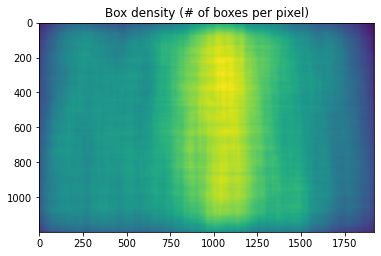

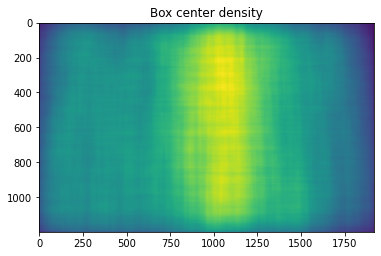

In [71]:
plt.imshow(box_density)
plt.title("Box density (# of boxes per pixel)")
plt.figure()
plt.imshow(box_center_density)
plt.title("Box center density")

2293.0
8.0


Text(0.5, 1.0, 'Prediction box center density')

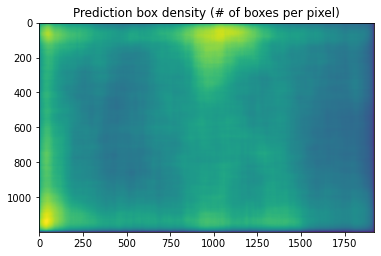

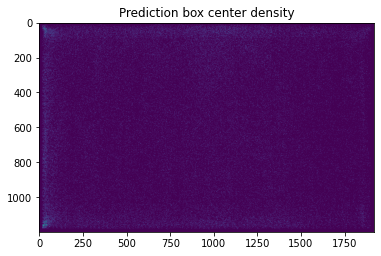

In [72]:
pred_density = np.zeros((1200, 1920))
pred_center_density = np.zeros_like(pred_density)
for box in yolov4_boxes:
    if np.sum(box) !=0:
        pred_density[box[1]:(box[1] + box[3]), box[0]:(box[0] + box[2])] += 1
        pred_center_density[(box[1]+(box[3]//2) - 1): (box[1]+(box[3]//2) + 1),(box[0]+(box[2]//2) - 1): (box[0]+(box[2]//2)+ 1) ] += 1

pred_count = np.copy(pred_density)
print(np.max(pred_density))
print(np.max(pred_center_density))
pred_density = pred_density / yolov4_boxes.shape[0]
pred_center_density = pred_center_density / yolov4_boxes.shape[0]
plt.imshow(pred_density)
plt.title("Prediction box density (# of boxes per pixel)")
plt.figure()
plt.imshow(pred_center_density)
plt.title("Prediction box center density")

In [67]:
gt_per_sample = get_boxes("ground_truth_detections_single.detections.bounding_box", 1920, 1200, False)
yolov4_per_sample = get_boxes("predictions_yolov4_csp_single.detections.bounding_box", 1920, 1200, False)
map_map = np.zeros((1200,1920,3))
for gt, yolo in tqdm.tqdm(zip(gt_per_sample, yolov4_per_sample)):
    gt_mask, _ = make_mask(gt, 1920, 1200)
    pred_mask, _ = make_mask(yolo, 1920, 1200)
    #True positives are pixel masked by yolo prediction and ground_truth
    map_map[:, :, 0] += np.logical_and(gt_mask>0, pred_mask>0) # true values will be true positives
    #False positives are pixel masked by yolo prediction, but not by ground truth
    map_map[:, :, 1] += np.logical_and(gt_mask==0, pred_mask>0) #true values will be false positives
    #False negatives are pixel masked by ground truth, but not by prediction 
    map_map[:, :, 2] += np.logical_and(gt_mask>0, pred_mask==0)


5510it [03:34, 25.70it/s]


0.5783132530120482


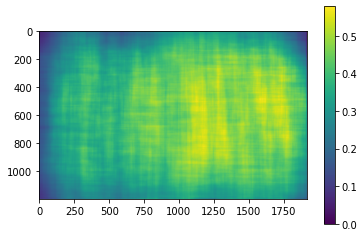

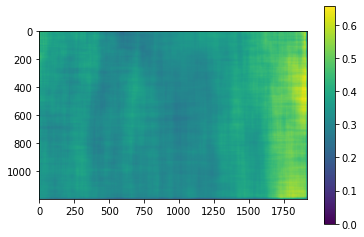

In [68]:
precision_map = map_map[:, :, 0] / (map_map[:, :, 0] + map_map[:, :, 1])
plt.imshow(precision_map)
print(np.max(precision_map))
plt.colorbar()

recall_map = map_map[:, :, 0] / (map_map[:, :, 0] + map_map[:, :, 2])
plt.figure()
plt.imshow(recall_map)
plt.colorbar()

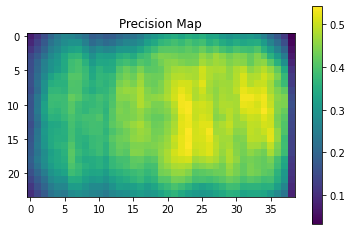

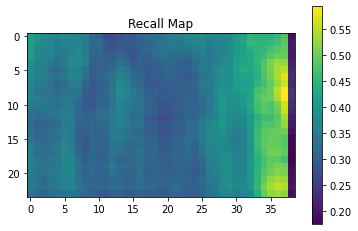

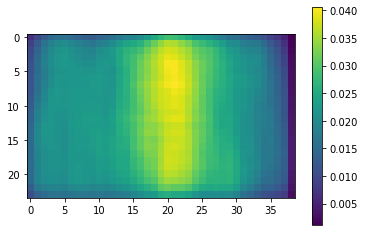

In [69]:
plt.imshow(block_reduce(precision_map, 50, np.mean))
plt.title("Precision Map")
plt.colorbar()
plt.figure()
plt.imshow(block_reduce(recall_map, 50, np.mean))
plt.title("Recall Map")
plt.colorbar()
plt.figure()
plt.imshow(block_reduce(box_density, 50, np.mean))
plt.colorbar()